# 5. Full inference pipeline

In [7]:
import torch
import numpy as np

from torch.utils.data import DataLoader
from data import *

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

df = pipeline()
time_steps = 48
y_time_steps = 12
datasets = samples(df, time_steps, y_time_steps)

/Users/alex/prog/uber-time-series/data.py:98: FutureWarning: DatetimeIndex.strides is deprecated and will be removed in a future version
  strides = (df.index.strides[0],df.index.strides[0]*time_steps)


## Algorithm 1

Section 3 of the paper

In [8]:
def mc_dropout(X, encoder, predictor, B=200):
    y_hat = []
    for _ in range(B):
        embedding = encoder(X).view(-1, 48)
        exogenous = X[:,-1,:]
        Z = torch.cat([embedding, exogenous], dim=1)
        out = predictor(Z).detach().numpy()
        y_hat.append(out)

    # prediction
    y_hat_mc = np.mean(y_hat, axis=0)
    
    # model uncertainty and misspecification
    eta1 = np.mean((np.array(y_hat) - y_hat_mc)**2)

    return y_hat_mc, np.sqrt(eta1)

## Algorithm 2

Section 3 of the paper

In [9]:
def inference(X, encoder, predictor, B=200):
    y_hat, eta1 = mc_dropout(X, encoder, predictor, B)
    
    valid_data = TrafficDataset(datasets, set_='valid')
    valid_dataloader = DataLoader(valid_data,
                                  batch_size=len(valid_data),
                                  shuffle=True)
    predictor.eval()
    for x, y in valid_dataloader:
        embedding = encoder(x).view(-1, 48)
        exogenous = x[:,-1,:]
        Z = torch.cat([embedding, exogenous], dim=1)
        y_v = predictor(Z)
    eta2 = np.mean((y_v.detach().numpy() - y.numpy())**2)
    
    # total uncertainty
    eta = np.sqrt(eta1**2 + eta2)
    
    return y_hat, eta

## Run inference

In [10]:
def dropout_on(m):
    if type(m) == torch.nn.Dropout:
        m.train()
    
autoencoder = torch.load('saved_models/autoencoder_dropout.pt').eval()
encoder     = autoencoder.encoder
predictor   = torch.load('saved_models/predictor.pt').eval().apply(dropout_on)

In [11]:
test_data = TrafficDataset(datasets, set_='test')
test_dataloader = DataLoader(test_data,
                             batch_size=len(test_data),
                             shuffle=True)
for x,y in test_dataloader:
    y_hat, eta = inference(x, encoder, predictor, B=200)


/Users/alex/prog/uber-time-series/data.py:14: RuntimeWarning: invalid value encountered in true_divide
  self.x[:,:,:4] = (self.x[:,:,:4] - self.mu) / self.std
/Users/alex/prog/uber-time-series/data.py:16: RuntimeWarning: invalid value encountered in true_divide
  self.y[:,:,:4] = (self.y[:,:,:4] - self.mu) / self.std


### Plot

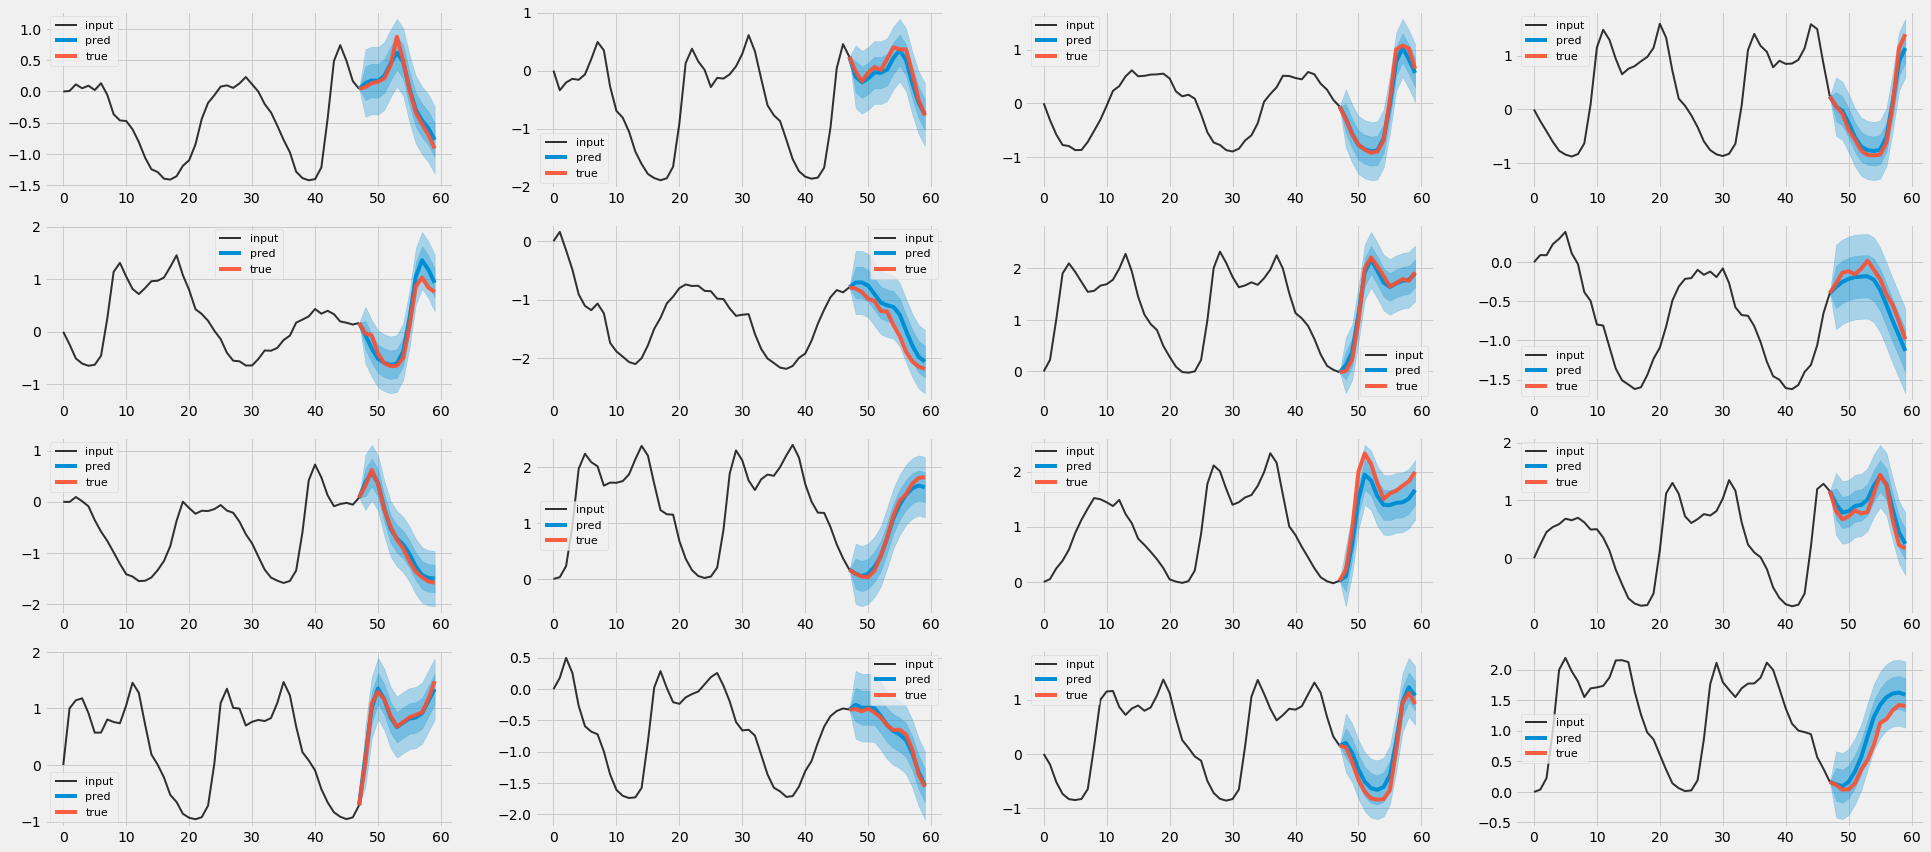

In [34]:
rows, cols = 4,4
fig = plt.figure(figsize=(7.5*cols,3.5*rows))
for p,i in enumerate(np.random.permutation(len(x))[:rows*cols]):
    ax = fig.add_subplot(rows,cols,p+1)
    ax.plot(np.arange(time_steps), x.detach().numpy()[i,:,3], lw=2, c='k', alpha=0.8, label='input')
    ax.fill_between(np.arange(y_time_steps+1) + time_steps-1,
                    np.concatenate([[x.detach().numpy()[i,-1,3]], y_hat[i]+2*eta]),
                    np.concatenate([[x.detach().numpy()[i,-1,3]], y_hat[i]-2*eta]),
                    color='C0',alpha=0.3)
    ax.fill_between(np.arange(y_time_steps+1) + time_steps-1,
                    np.concatenate([[x.detach().numpy()[i,-1,3]], y_hat[i]+1*eta]),
                    np.concatenate([[x.detach().numpy()[i,-1,3]], y_hat[i]-1*eta]),
                    color='C0',alpha=0.3)
    ax.plot(np.arange(y_time_steps+1) + time_steps-1,
            np.concatenate([[x.detach().numpy()[i,-1,3]], y_hat[i]]), label='pred')
    ax.plot(np.arange(y_time_steps+1) + time_steps-1,
            np.concatenate([[x.detach().numpy()[i,-1,3]], y[i,:].numpy()]),
            alpha=0.9, label='true')
    ax.legend(fontsize=11)
plt.savefig('predictions.png', dpi=180)